### prepare environment

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
cd /content/drive/MyDrive/PointingDSP/PointingDSP2021/2021_Analysis

/content/drive/MyDrive/PointingDSP/PointingDSP2021/2021_Analysis


### Shortcutting task

In [3]:
#load shortcutting performance
sc = pd.read_csv('ShortcuttingPerformanceRaw.csv')

In [4]:
sc.head()

,subject,TrialNo,TrialID,strategy,Order,total_dis,Top,Target,short_dis,learn_dis,Start_x,Start_y,Goal_x,Goal_y,Distance,ES,EL
0,605,1,dsp1_18,shortcut,1,142.0,Trashcan,well,142,264,53,194,174,173,115.333,1.000000,0.537879
1,605,2,dsp1_23,learned,2,404.0,harp,plant,164,404,134,153,93,30,126.667,2.463415,1.000000
2,605,3,dsp1_17,reverse learned,3,305.0,trashcan,picnic table,183,669,53,194,73,71,130.667,1.666667,0.455904
3,605,4,dsp1_19,shortcut liberal,4,183.0,bookshelf,plant,143,547,73,153,93,30,118.667,1.279720,0.334552
4,605,5,dsp1_11,shortcut,5,82.0,picnic table,wheelbarrow,82,448,73,71,114,112,44.000,1.000000,0.183036


In [5]:
sc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1180 entries, 0 to 1179
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   subject    1180 non-null   int64  
 1   TrialNo    1180 non-null   int64  
 2   TrialID    1180 non-null   object 
 3   strategy   1180 non-null   object 
 4   Order      1180 non-null   int64  
 5   total_dis  1180 non-null   float64
 6   Top        1180 non-null   object 
 7   Target     1180 non-null   object 
 8   short_dis  1180 non-null   int64  
 9   learn_dis  1180 non-null   int64  
 10  Start_x    1180 non-null   int64  
 11  Start_y    1180 non-null   int64  
 12  Goal_x     1180 non-null   int64  
 13  Goal_y     1180 non-null   int64  
 14  Distance   1180 non-null   float64
 15  ES         1180 non-null   float64
 16  EL         1180 non-null   float64
dtypes: float64(4), int64(9), object(4)
memory usage: 156.8+ KB


#### problematic subjects and trials

In [6]:
#detect problematic subjects (>6 failure trials)
sub_fail = sc.groupby(['subject']).apply(lambda x: (x['strategy']=='Failure').sum()).reset_index(name='total_failure')
sub_fail[sub_fail['total_failure']>6]

,subject,total_failure
32,638,7
33,639,8


In [7]:
#detect problematic trials (>20% unsuccessful participants)
trial_fail = sc.groupby(['TrialID']).apply(lambda x: (x['strategy']=='Failure').sum()).reset_index(name='total_failure')
trial_fail[trial_fail['total_failure']>(len(sub_fail)*0.2)]

,TrialID,total_failure
17,dsp1_22,17


In [8]:
print('Participants with > 6 fialure trials : ')
p_sub=sub_fail[sub_fail['total_failure']>6]['subject'].tolist()
print(p_sub)
print('Trials with > 20% fialure subjects : ')
p_trial = trial_fail[trial_fail['total_failure']>(len(sub_fail)*0.2)]['TrialID'].tolist()
print(p_trial)

Participants with > 6 fialure trials : 
[638, 639]
Trials with > 20% fialure subjects : 
['dsp1_22']


In [9]:
#excluded unsuccessful participants and trials
valid_sc = sc.loc[~(sc['TrialID'].isin(p_trial) | sc['subject'].isin(p_sub)),:]

In [10]:
valid_sc.subject.nunique()

57

In [11]:
valid_sc.TrialID.nunique()

19

In [12]:
#replace ES for unsuccessful trials as the mean across all the other trials
valid_sc.loc[(valid_sc.strategy == 'Failure'),'ES']= np.NaN
valid_sc['ES'] = valid_sc.groupby("subject")['ES'].transform(lambda x: x.fillna(x.mean()))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
# percentage of successful trials:
valid_sc[(valid_sc['strategy']!='Failure')].shape[0]/valid_sc.shape[0]

0.9289012003693444

### pointing task

#### read data

In [14]:
point_raw = pd.read_csv('PointingData.csv')
point = point_raw[point_raw['Subject'].isin(valid_sc.subject.unique().tolist())]
point_pre = point[point['Order']=='pre']

In [15]:
round(point_pre.groupby('Subject')['AbsoluError'].mean().describe(),2)

count     57.00
mean      74.12
std       25.24
min       12.09
25%       60.56
50%       80.04
75%       94.86
max      106.46
Name: AbsoluError, dtype: float64

#### comparing to chance performance

In [16]:
stats.ttest_1samp(point_pre.groupby('Subject')['AbsoluError'].mean(), popmean = 90)

Ttest_1sampResult(statistic=-4.748094096332848, pvalue=1.4655450473766163e-05)

In [17]:
def CI_conhen(var,mu):
  print("95% Confidence Interval: {}".format(stats.t.interval(0.95, var.size - 1, var.mean(), stats.sem(var))))
  cohen_d = ( var.mean() - mu )/var.std()
  print("cohen_d {}".format(round(cohen_d,2)))

CI_conhen(point_pre.groupby('Subject')['AbsoluError'].mean(),90)

95% Confidence Interval: (67.4260932479352, 80.82224983198682)
cohen_d -0.63


### T1: Descriptive Stats for all

In [18]:
point_post = point[point['Order']=='post']
sc_sub = valid_sc.groupby('subject')['ES'].mean().reset_index()
pointpre_sub = point_pre.groupby('Subject')['AbsoluError'].mean().reset_index().\
              rename(columns={'Subject':'subject','AbsoluError':'Point_PreError'})
pointpost_sub = point_post.groupby('Subject')['AbsoluError'].mean().reset_index().rename(columns={'Subject':'subject','AbsoluError':'Point_PostError'})
from functools import reduce
sub_performance = reduce(lambda x,y: pd.merge(x,y, on='subject', how='outer'), [sc_sub,pointpre_sub,pointpost_sub])
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sub_performance.iloc[:,1:].describe()

,ES,Point_PreError,Point_PostError
count,57.00,57.00,57.00
mean,1.82,74.12,63.53
std,0.38,25.24,25.38
min,1.02,12.09,8.52
25%,1.53,60.56,45.21
50%,1.82,80.04,67.54
75%,2.11,94.86,80.64
max,2.55,106.46,112.37


In [19]:
from scipy.stats import kurtosis
from scipy.stats import skew

In [20]:
#Skewness
skew(sub_performance.iloc[:,1:])

array([-0.20511285, -0.83560136, -0.26402713])

In [21]:
#Kurtosis
kurtosis(sub_performance.iloc[:,1:])

array([-0.83260369, -0.1260541 , -0.69104413])

In [22]:
pip install researchpy

In [23]:
from researchpy import ttest
import researchpy

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [24]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
rpRes = ttest(sub_performance['Point_PreError'], sub_performance['Point_PostError'], equal_variances=True, paired=True)
rpRes

(          Variable      N   Mean     SD    SE  95% Conf.  Interval
 0   Point_PreError 57.000 74.124 25.244 3.344     67.426    80.822
 1  Point_PostError 57.000 63.527 25.377 3.361     56.794    70.261
 2             diff 57.000 10.597 16.127 2.136      6.318    14.876,
                               Paired samples t-test  results
 0  Difference (Point_PreError - Point_PostError) =    10.597
 1                             Degrees of freedom =    56.000
 2                                              t =     4.961
 3                          Two side test p value =     0.000
 4                         Difference < 0 p value =     1.000
 5                         Difference > 0 p value =     0.000
 6                                      Cohen's d =     0.419
 7                                      Hedge's g =     0.416
 8                                  Glass's delta =     0.420
 9                                    Pearson's r =     0.553)

#### Reliability

In [25]:
%load_ext rpy2.ipython

In [26]:
%%R
install.packages("splithalf")
library("splithalf")

R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/splithalf_0.7.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 176126 bytes (171 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wr

In [27]:
%%R -i point_pre
set.seed(123)
splithalf(data=point_pre,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AbsoluError",
          var.trialnum = "DSP_Trial",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 57          0.85    0.8     0.9
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.85, 95% CI [0.8, 0.9]"


In [28]:
%%R -i valid_sc
set.seed(123)
splithalf(data=valid_sc,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "ES",
          var.trialnum = "TrialID",
          var.participant = "subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 57          0.71   0.59     0.8
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.71, 95% CI [0.59, 0.8]"


In [29]:
%%R -i point_post
set.seed(123)
splithalf(data=point_post,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AbsoluError",
          var.trialnum = "DSP_Trial",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 57          0.86   0.81    0.91
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.86, 95% CI [0.81, 0.91]"


### Overall Travel Efficiency

In [30]:
# travel efficiency for all learned routes
trial = pd.read_csv('Exp1trialfeature.csv')
all_learn_effi = trial[trial['DSP_Trial'].isin(valid_sc.TrialID.unique().tolist())].apply(lambda x: x['learn_dis']/x['short_dis'],axis=1).mean()
print(all_learn_effi)

2.5069939399670558


In [31]:
# one-sample t test against Travel Efficiency = 2.51
print(stats.ttest_1samp(sub_performance.ES, popmean = all_learn_effi))
CI_conhen(sub_performance.ES,all_learn_effi)

Ttest_1sampResult(statistic=-13.524637659628452, pvalue=2.7545283347316305e-19)
95% Confidence Interval: (1.718938589539873, 1.9222715275338316)
cohen_d -1.79


In [32]:
# one-sample t test against Travel Efficiency = 1
print(stats.ttest_1samp(sub_performance.ES, popmean = 1))
CI_conhen(sub_performance.ES,1)

Ttest_1sampResult(statistic=16.16923930242551, pvalue=9.311839392223252e-23)
95% Confidence Interval: (1.718938589539873, 1.9222715275338316)
cohen_d 2.14


### Figure 4

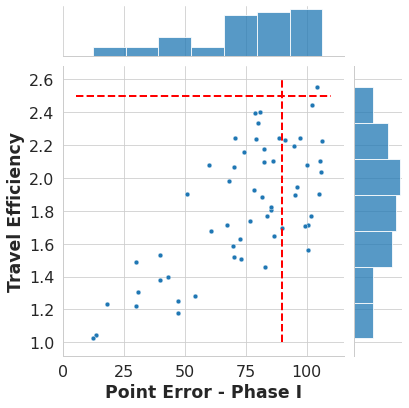

In [33]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8)
g = sns.jointplot(data=sub_performance, x="Point_PreError", y="ES")
g.ax_joint.set_xlabel('Point Error - Phase I', fontweight='bold')
g.ax_joint.set_ylabel('Travel Efficiency', fontweight='bold')
g.ax_joint.plot([90,90], [1,2.6], 'r--', linewidth = 2)
g.ax_joint.plot([5,110], [2.5,2.5], 'r--', linewidth = 2)
plt.show()

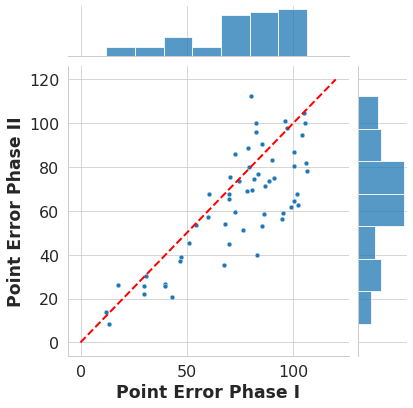

In [34]:
g = sns.jointplot(data=sub_performance, x="Point_PreError", y="Point_PostError")
g.ax_joint.set_xlabel('Point Error Phase I', fontweight='bold')
g.ax_joint.set_ylabel('Point Error Phase II', fontweight='bold')
g.ax_joint.plot([0,120], [0,120], 'r--', linewidth = 2)
plt.show()

### T2: Observed and Disattenuated Correlation for all

In [35]:
sub_performance[['ES','Point_PreError','Point_PostError']].corr()

,ES,Point_PreError,Point_PostError
ES,1.000,0.706,0.738
Point_PreError,0.706,1.000,0.797
Point_PostError,0.738,0.797,1.000


In [36]:
#Travel Efficiency - SplitHalf:0.70
print(0.706202/math.sqrt(0.85*0.71))
print(0.738309/math.sqrt(0.86*0.71))
print(0.797031/math.sqrt(0.86*0.85))

0.9090553057823283
0.9448432450666707
0.9322159403561883


### T3: Descriptive Stats for Low & High Spatials

In [37]:
print(sub_performance.Point_PreError.median())

80.04074074074073


In [38]:
#### categorize people as low spatial participants v.s. high spatial participants
pt_h = sub_performance[sub_performance.Point_PreError<sub_performance.Point_PreError.median()]
pt_l = sub_performance[sub_performance.Point_PreError>=sub_performance.Point_PreError.median()]
pt_l_sub = pt_l.subject.tolist()
pt_h_sub = pt_h.subject.tolist()
sub_performance['HighSpatial']=sub_performance.Point_PreError<sub_performance.Point_PreError.median()
sub_performance['point_improv']=sub_performance.Point_PreError - sub_performance.Point_PostError

In [39]:
pt_h.iloc[:,1:].describe()

,ES,Point_PreError,Point_PostError
count,28.000,28.000,28.000
mean,1.633,54.398,48.192
std,0.390,21.087,22.907
min,1.023,12.085,8.519
25%,1.301,39.717,26.434
50%,1.559,60.167,48.311
75%,1.942,71.000,67.634
max,2.398,79.256,88.637


In [40]:
skew(pt_h.iloc[:,1:])

array([ 0.3060126 , -0.60737072,  0.07671329])

In [41]:
kurtosis(pt_h.iloc[:,1:])

array([-0.98858859, -0.86744595, -1.12904001])

In [42]:
pt_l.iloc[:,1:].describe()

,ES,Point_PreError,Point_PostError
count,29.000,29.000,29.000
mean,2.002,93.170,78.334
std,0.279,8.994,17.882
min,1.461,80.041,39.787
25%,1.769,85.307,64.334
50%,2.034,94.863,76.674
75%,2.222,100.567,94.754
max,2.551,106.463,112.369


In [43]:
skew(pt_l.iloc[:,1:])

array([ 0.02001207,  0.02408177, -0.01895073])

In [44]:
kurtosis(pt_l.iloc[:,1:])

array([-0.85791307, -1.49809872, -0.7436326 ])

#### Reliability for low and high spatials

In [45]:
point_pre_l = point_pre[point_pre.Subject.isin(pt_l_sub)]
point_pre_h = point_pre[point_pre.Subject.isin(pt_h_sub)]
sc_l = valid_sc[valid_sc.subject.isin(pt_l_sub)]
sc_h = valid_sc[valid_sc.subject.isin(pt_h_sub)]
point_post_l = point_post[point_post.Subject.isin(pt_l_sub)]
point_post_h = point_post[point_post.Subject.isin(pt_h_sub)]

In [46]:
%%R -i point_pre_l
set.seed(123)
splithalf(data=point_pre_l,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AbsoluError",
          var.trialnum = "DSP_Trial",
          var.participant = "Subject",
          average="mean")


  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 29         -0.19  -0.52    0.28
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was -0.19, 95% CI [-0.52, 0.28]"


In [47]:
%%R -i point_pre_h
set.seed(123)
splithalf(data=point_pre_h,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AbsoluError",
          var.trialnum = "DSP_Trial",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 28          0.82   0.72    0.91
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.82, 95% CI [0.72, 0.91]"


In [48]:
%%R -i sc_l
set.seed(123)
splithalf(data=sc_l,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "ES",
          var.trialnum = "TrialID",
          var.participant = "subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 29          0.31  -0.06     0.6
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.31, 95% CI [-0.06, 0.6]"


In [49]:
%%R -i sc_h
set.seed(123)
splithalf(data=sc_h,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "ES",
          var.trialnum = "TrialID",
          var.participant = "subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 28          0.79   0.64     0.9
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.79, 95% CI [0.64, 0.9]"


In [50]:
%%R -i point_post_l
set.seed(123)
splithalf(data=point_post_l,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AbsoluError",
          var.trialnum = "DSP_Trial",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 29          0.68   0.48    0.82
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.68, 95% CI [0.48, 0.82]"


In [51]:
%%R -i point_post_h
set.seed(123)
splithalf(data=point_post_h,
          outcome = "accuracy",
          score = "average",
          halftype = "random",
          permutations = 5000,
          var.ACC = "AbsoluError",
          var.trialnum = "DSP_Trial",
          var.participant = "Subject",
          average="mean")

  |======================================================================| 100%[1] "condition all complete"
[1] "Calculating split half estimates"
[1] "split half estimates for 5000 random splits"
  condition  n spearmanbrown SB_low SB_high
1       all 28          0.87   0.78    0.93
[1] "this could be reported as: using 5000 random splits, the spearman-brown corrected reliability  estimate for the all condition was 0.87, 95% CI [0.78, 0.93]"


### Low Spatials

In [52]:
### comparing with the chance performance
print(stats.ttest_1samp(pt_l.Point_PreError, popmean = 90))
CI_conhen(pt_l.Point_PreError,90)

Ttest_1sampResult(statistic=1.8981296527449827, pvalue=0.06803197125079394)
95% Confidence Interval: (89.74900760577538, 96.59147770712374)
cohen_d 0.35


In [53]:
print(stats.ttest_1samp(pt_l.ES, popmean = 2.51))
CI_conhen(pt_l.ES,2.51)

Ttest_1sampResult(statistic=-9.79959734849809, pvalue=1.5019240621271658e-10)
95% Confidence Interval: (1.8953698691215641, 2.1078972615082567)
cohen_d -1.82


In [54]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
rpRes = ttest(pt_l['Point_PreError'], pt_l['Point_PostError'], equal_variances=True, paired=True)
rpRes

(          Variable      N   Mean     SD    SE  95% Conf.  Interval
 0   Point_PreError 29.000 93.170  8.994 1.670     89.749    96.591
 1  Point_PostError 29.000 78.334 17.882 3.321     71.532    85.136
 2             diff 29.000 14.837 19.073 3.542      7.582    22.091,
                               Paired samples t-test  results
 0  Difference (Point_PreError - Point_PostError) =    14.836
 1                             Degrees of freedom =    28.000
 2                                              t =     4.189
 3                          Two side test p value =     0.000
 4                         Difference < 0 p value =     1.000
 5                         Difference > 0 p value =     0.000
 6                                      Cohen's d =     1.104
 7                                      Hedge's g =     1.089
 8                                  Glass's delta =     1.650
 9                                    Pearson's r =     0.621)

In [55]:
print(stats.ttest_1samp(pt_l.Point_PostError, popmean = 90))
CI_conhen(pt_l.Point_PostError,90)

Ttest_1sampResult(statistic=-3.5133857415229808, pvalue=0.0015225112719128228)
95% Confidence Interval: (71.53192799439434, 85.13550201633872)
cohen_d -0.65


### T4: Correlations for Low and High Spatials

In [56]:
pt_l[['ES','Point_PreError','Point_PostError']].corr()

,ES,Point_PreError,Point_PostError
ES,1.000,0.092,0.370
Point_PreError,0.092,1.000,0.115
Point_PostError,0.370,0.115,1.000


In [57]:
def bi_pr_test(r_c,N):
  df = N-2
  t_value = r_c * np.sqrt(df) / np.sqrt(1-r_c**2)
  p_value = stats.t.sf(abs(t_value), df)*2  # two-sided pvalue = Prob(abs(t)>tt)
  z_u = np.log((1+r_c)/(1-r_c))/2 + 1.96*np.sqrt(1/(N-3))
  z_l = np.log((1+r_c)/(1-r_c))/2 - 1.96*np.sqrt(1/(N-3))
  r_u = (np.exp(2*z_u)-1)/(np.exp(2*z_u)+1)
  r_l = (np.exp(2*z_l)-1)/(np.exp(2*z_l)+1)
  print('t-statistic = %5.3f pvalue = %6.4f df = %2.0f' % (t_value,p_value,df))
  print('95CI = [%4.2f, %4.2f]' % (r_l,r_u))

In [58]:
bi_pr_test(0.09245531549954707,27)

t-statistic = 0.464 pvalue = 0.6465 df = 25
95CI = [-0.30, 0.46]


In [59]:
bi_pr_test(0.3701474991502444,27)

t-statistic = 1.992 pvalue = 0.0574 df = 25
95CI = [-0.01, 0.66]


In [60]:
0.37/np.sqrt(0.68*0.31)

0.8058726574577093

In [61]:
pt_h[['ES','Point_PreError','Point_PostError']].corr()

,ES,Point_PreError,Point_PostError
ES,1.000,0.777,0.797
Point_PreError,0.777,1.000,0.876
Point_PostError,0.797,0.876,1.000


In [62]:
print(0.78/np.sqrt(0.82*0.79))
print(0.88/np.sqrt(0.82*0.87))
print(0.80/np.sqrt(0.79*0.87))

0.9691123561673313
1.041876205445766
0.9649766731017068


### High Spatials

In [63]:
print(stats.ttest_1samp(pt_h.Point_PreError, popmean = 90))
CI_conhen(pt_h.Point_PreError,90)

Ttest_1sampResult(statistic=-8.934031788038578, pvalue=1.5043342454361348e-09)
95% Confidence Interval: (46.221339052458006, 62.57442814330919)
cohen_d -1.69


In [64]:
# create a list of our conditions
conditions = [sub_performance.subject.isin(pt_h_sub),
              sub_performance.subject.isin(pt_l_sub)]
# create a list of the values we want to assign for each condition
values = ['High','Low']
# create a new column and use np.select to assign values to it using our lists as arguments
sub_performance['Group'] = np.select(conditions, values)

In [65]:
from scipy.stats import ttest_ind
from scipy.stats import t

def welch_ttest_CI(x1, x2,alternative):
    
    n1 = x1.size
    n2 = x2.size
    m1 = np.mean(x1)
    m2 = np.mean(x2)
    
    v1 = np.var(x1, ddof=1)
    v2 = np.var(x2, ddof=1)
    
    pooled_se = np.sqrt(v1 / n1 + v2 / n2)
    delta = m1-m2
    
    tstat = delta /  pooled_se
    df = (v1 / n1 + v2 / n2)**2 / (v1**2 / (n1**2 * (n1 - 1)) + v2**2 / (n2**2 * (n2 - 1)))
    
    # two side t-test
    p = 2 * t.cdf(-abs(tstat), df)
    
    # upper and lower bounds
    lb = delta - t.ppf(0.975,df)*pooled_se 
    ub = delta + t.ppf(0.975,df)*pooled_se
  
    return pd.DataFrame(np.array([delta,lb,ub]).reshape(1,-1),
                         columns=['Difference in mean','lb','ub'])

In [66]:
welch_ttest_CI(pt_h.ES,pt_l.ES,'equal')

,Difference in mean,lb,ub
0,-0.369,-0.550,-0.187


In [67]:
rpRes = ttest(pt_h.ES,pt_l.ES, equal_variances= False)
rpRes

(   Variable      N  Mean    SD    SE  95% Conf.  Interval
 0        ES 28.000 1.633 0.390 0.074      1.482     1.784
 1        ES 29.000 2.002 0.279 0.052      1.895     2.108
 2  combined 57.000 1.821 0.383 0.051      1.719     1.922,
               Welch's t-test  results
 0    Difference (ES - ES) =    -0.368
 1      Degrees of freedom =    50.434
 2                       t =    -4.090
 3   Two side test p value =     0.000
 4  Difference < 0 p value =     0.000
 5  Difference > 0 p value =     1.000
 6               Cohen's d =    -1.090
 7               Hedge's g =    -1.075
 8           Glass's delta =    -0.946
 9             Pearson's r =     0.499)

In [68]:
rpRes = ttest(pt_h['Point_PreError'], pt_h['Point_PostError'], equal_variances=True, paired=True)
rpRes

(          Variable      N   Mean     SD    SE  95% Conf.  Interval
 0   Point_PreError 28.000 54.398 21.087 3.985     46.221    62.574
 1  Point_PostError 28.000 48.192 22.907 4.329     39.309    57.074
 2             diff 28.000  6.206 11.085 2.095      1.908    10.504,
                               Paired samples t-test  results
 0  Difference (Point_PreError - Point_PostError) =     6.206
 1                             Degrees of freedom =    27.000
 2                                              t =     2.963
 3                          Two side test p value =     0.006
 4                         Difference < 0 p value =     0.997
 5                         Difference > 0 p value =     0.003
 6                                      Cohen's d =     0.282
 7                                      Hedge's g =     0.278
 8                                  Glass's delta =     0.294
 9                                    Pearson's r =     0.495)

In [69]:
rpRes = ttest(pt_h['Point_PreError'], pt_h['Point_PostError'], equal_variances=True, paired=True)
rpRes

(          Variable      N   Mean     SD    SE  95% Conf.  Interval
 0   Point_PreError 28.000 54.398 21.087 3.985     46.221    62.574
 1  Point_PostError 28.000 48.192 22.907 4.329     39.309    57.074
 2             diff 28.000  6.206 11.085 2.095      1.908    10.504,
                               Paired samples t-test  results
 0  Difference (Point_PreError - Point_PostError) =     6.206
 1                             Degrees of freedom =    27.000
 2                                              t =     2.963
 3                          Two side test p value =     0.006
 4                         Difference < 0 p value =     0.997
 5                         Difference > 0 p value =     0.003
 6                                      Cohen's d =     0.282
 7                                      Hedge's g =     0.278
 8                                  Glass's delta =     0.294
 9                                    Pearson's r =     0.495)

In [70]:
rpRes = ttest(sub_performance[sub_performance['HighSpatial']].point_improv,sub_performance[~sub_performance['HighSpatial']].point_improv,equal_variances = False,paired=False)
rpRes

(       Variable      N   Mean     SD    SE  95% Conf.  Interval
 0  point_improv 28.000  6.206 11.085 2.095      1.908    10.504
 1  point_improv 29.000 14.837 19.073 3.542      7.582    22.091
 2      combined 57.000 10.597 16.127 2.136      6.318    14.876,
                                 Welch's t-test  results
 0  Difference (point_improv - point_improv) =    -8.630
 1                        Degrees of freedom =    46.519
 2                                         t =    -2.097
 3                     Two side test p value =     0.042
 4                    Difference < 0 p value =     0.021
 5                    Difference > 0 p value =     0.979
 6                                 Cohen's d =    -0.551
 7                                 Hedge's g =    -0.543
 8                             Glass's delta =    -0.779
 9                               Pearson's r =     0.294)

In [72]:
welch_ttest_CI(sub_performance[sub_performance['HighSpatial']].point_improv,sub_performance[~sub_performance['HighSpatial']].point_improv,'equal')

,Difference in mean,lb,ub
0,-8.630,-16.917,-0.344
